In [1]:
import cPickle as pkl
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

'''
import random
'''

'\nimport random\n'

In [2]:
filepath = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"

In [3]:
results = pkl.load(open(filepath))

In [4]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

In [5]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 167.580508475
YAL038W 141.609887006
YJL189W 133.568361582
YCR012W 129.352259887
YOL086C 135.939548023
YLR110C 124.482047516
YLR044C 223.223163842
YKL152C 132.904884319


In [6]:
transcriptome_shah = pkl.load(open('../parameters/transcriptome_shah.p'))

In [7]:
prot_per_transcript_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_per_transcript_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / \
        transcriptome_shah[prot] / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_per_transcript_speeds[prot] > 0.25: 
        print prot, prot_per_transcript_speeds[prot]

YJL158C 0.251702025481
YDR461W 0.267514124294
YDR224C 0.258764371875
YLR388W 0.266384180791


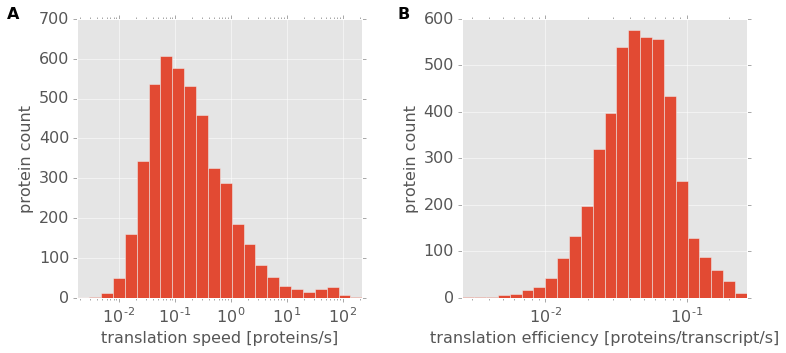

In [8]:
plt.rcParams['figure.figsize'] = (12, 5)

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121)
n, bins, patches = ax.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 25))
ax.set_xscale("log")
ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
ax.set_xlabel('translation speed [proteins/s]', fontsize=16)
ax.set_ylabel('protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0001, 700, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(122)
n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                              np.log10(max(prot_per_transcript_speeds.values())), 32))
ax.set_xscale("log")
ax.set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
ax.set_xlabel('translation efficiency [proteins/transcript/s]', fontsize=16)
ax.set_ylabel('protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0009, 600, "B", fontsize=16, weight="bold")

plt.show()

In [9]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [10]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

/home/martin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [11]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [12]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [13]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [14]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [15]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic toc [s]']

In [16]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [17]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [18]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

In [20]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

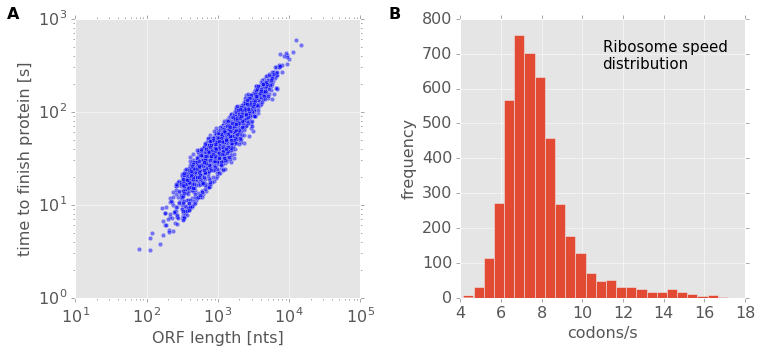

In [33]:
plt.rcParams['figure.figsize'] = (12, 5)

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121)
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.5)
ax.set_xlabel('ORF length [nts]', fontsize=16)
ax.set_ylabel('time to finish protein [s]', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')

plt.text(1.1, 1000, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(122)
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5))
ax.set_xlabel('codons/s', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

plt.text(0.5, 800, "B", fontsize=16, weight="bold")
#plt.title("") #, weight="bold")
ax.text(.5, .82, 'Ribosome speed\ndistribution', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.show()

## Ribosome ramp

In [21]:
import shelve

filepath = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2052.db"
d = shelve.open(filepath)

In [22]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last polysome to catch steady state

    # Select only every third element (the others are zero anyway):
    # translate the model's polysome format to lattice of ones and zeros:
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

This is now a dictionary that contains for every gene an array of the total ribosomes bound at the corresponding codon positions.

In [23]:
avg_ribos_per_gene = {}

for gene in ribo_lattice_dict:
    avg_ribos_per_gene[gene] = np.mean(ribo_lattice_dict[gene])

In [24]:
z = {}

for gene in ribo_lattice_dict:
    if avg_ribos_per_gene[gene]>0:
        z[gene] = ribo_lattice_dict[gene] / avg_ribos_per_gene[gene]

In [25]:
ramp_genes = set(z.keys()) & set(orf_lengths.keys())
len(ramp_genes)

4338

In [26]:
max_gene_length = max(orf_lengths.values())/3.0
max_gene_length

4911.0

In [27]:
import math

e = []
for j in range(int(max_gene_length)):
    numer = 0.0
    for gene in ramp_genes:
        if orf_lengths[gene]/3 > j:
            if not math.isnan(z[gene][j]):
                numer += z[gene][j]
    denom = sum([1 if orf_lengths[gene] >= j else 0 for gene in ramp_genes]) * 1.0
    e.append(numer/denom)

In [28]:
eprime = np.array(e) / (sum(e[449:500]) / 51.0)

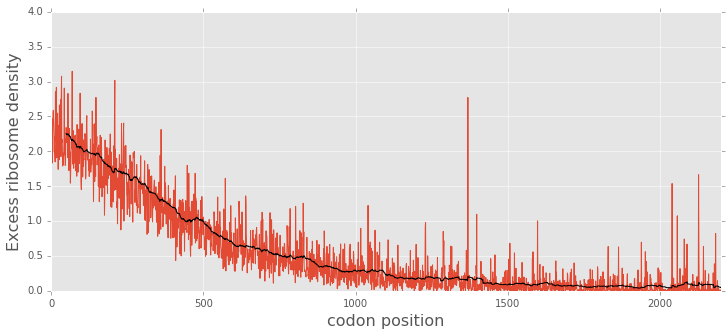

In [29]:
plt.plot(eprime)
plt.xlabel('codon position', fontsize=16)
plt.ylabel('Excess ribosome density', fontsize=16)
pd.rolling_mean(pd.Series(eprime), 50).plot(style='k')
plt.xlim([0, 2200]);
plt.ylim([0, 4]);

## Codon analysis

In [30]:
transcriptome = pkl.load(open('../parameters/transcriptome_shah.p'))

In [31]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

In [32]:
# length of longest polysome in codons
max_codons = len(max(ribo_lattice_dict.values(), key=len))

# fill up with None values
for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], \
                                        [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [33]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)

In [34]:
ribo_lattice_df_normalized = pd.DataFrame()

for column in ribo_lattice_df:
    ribo_lattice_df_normalized[column] = ribo_lattice_df[column]/float(transcriptome[column])

In [35]:
sigmas = {gene: np.std(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}
means = {gene: np.mean(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}

In [36]:
threshold = 5  # this many standard deviations above the mean are required for a signal to be classified as a peak

peaks = {gene: [(pos, value, (value - means[gene]) / sigmas[gene]) for (pos, value) 
                in enumerate(ribo_lattice_df_normalized[gene]) if (value - means[gene]) / sigmas[gene] > threshold] 
         for gene in sigmas if sigmas[gene] != 0
         }
        # and gene in high_transcript_abundance_genes}  # delete this to include all genes

In [37]:
peaks['YDL130W'], peaks['YBR078W']

([], [(410, 0.11904761904761904, 8.2102831036983535)])

In [38]:
from translation.TRSL_specific import codon_anticodon, tRNA_types, chunker, complement
codons_at_peaks = {gene: [orf_genomic_dict[gene][elem[0]*3:elem[0]*3+3] for elem in peaks[gene]] for gene in peaks}
anticodons_at_peaks = {gene: [codon_anticodon[codon] for codon in codons_at_peaks[gene]]
                       for gene in codons_at_peaks}

from itertools import chain
def flatten_dict_values(dictionary):
    return list(chain(*dictionary.values()))

from collections import Counter
counter = Counter(flatten_dict_values(anticodons_at_peaks))

import collections as col
counter = col.OrderedDict(sorted(counter.items(), key=lambda t: t[1]))

In [40]:
anticodon_tRNA_abundancy = {tRNA_types[id]['anticodon']: tRNA_types[id]['abundancy'] for id in tRNA_types}

In [56]:
transcriptome_weighted_orfs = [orf_genomic_dict[gene] * transcriptome[gene] for gene in transcriptome 
                               if gene in orf_genomic_dict]

In [57]:
anticodon_demand_transcriptome = Counter([codon_anticodon[item] for sublist in [list(chunker(sequence, 3)) 
                                          for sequence in transcriptome_weighted_orfs] 
                                              for item in sublist])

In [70]:
counter

OrderedDict([('ccg', 143),
             ('cca', 158),
             ('ucu', 175),
             ('acg', 221),
             ('cuu', 240),
             ('ugg', 250),
             ('caa', 259),
             ('gcc', 278),
             ('aac', 281),
             ('agu', 319),
             ('agc', 336),
             ('uug', 344),
             ('uuc', 353),
             ('uaa', 365),
             ('gca', 366),
             ('gug', 374),
             ('cau', 380),
             ('aga', 388),
             ('ugu', 434),
             ('aau', 442),
             ('ugc', 476),
             ('cac', 481),
             ('gua', 494),
             ('uac', 540),
             ('uga', 555),
             ('gaa', 566),
             ('guc', 585),
             ('ucc', 606),
             ('uuu', 621),
             ('cgu', 746),
             ('uau', 793),
             ('cga', 808),
             ('ccu', 859),
             ('guu', 890),
             ('cuc', 928),
             ('uag', 943),
             ('gcu', 948),
 

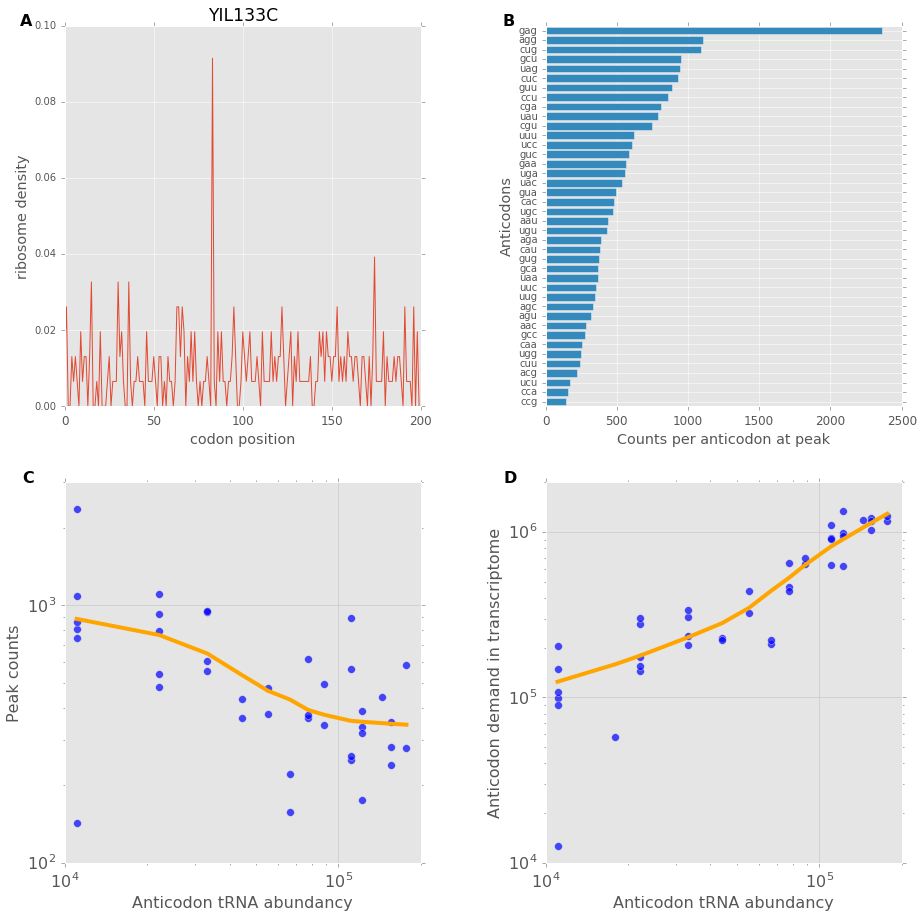

In [75]:
plt.rcParams['figure.figsize'] = (15, 15)

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['ytick.labelsize'] = 10

####################################################################
ax = fig.add_subplot(221)

ax.plot(ribo_lattice_df_normalized["YIL133C"])
ax.set_xlabel('codon position')
ax.set_ylabel('ribosome density')
ax.set_title("YIL133C")
        
plt.text(-25, 0.1, "A", fontsize=16, weight="bold")

####################################################################
ax = fig.add_subplot(222)

# make a horizontal bar chart
val = counter.values()    # the bar lengths
pos = np.arange(len(counter))+.5    # the bar centers on the y axis

plt.barh(pos, val, align='center')
plt.yticks(pos, counter.keys())
plt.xlabel('Counts per anticodon at peak')
plt.ylabel('Anticodons')
plt.grid(True)

plt.text(-300, 40, "B", fontsize=16, weight="bold")

####################################################################
ax = fig.add_subplot(223)

dict1 = anticodon_tRNA_abundancy
dict2 = counter
xaxislabel = "Anticodon tRNA abundancy"
yaxislabel = "Peak counts"
fontsize = 16
alpha = 0.7


plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-', color = '0.75')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
if yaxislabel:
    ax.set_ylabel(yaxislabel)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

scat = plt.scatter(xs, ys, s=60)
scat.set_alpha(alpha)

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points]
new_ys = [point[1] for point in sorted_points]
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, 'orange', linewidth=4)
plt.xlim([1e4, 2e5])
plt.ylim([1e2, 3e3])

plt.text(7e3, 3e3, "C", fontsize=16, weight="bold")

####################################################################
ax = fig.add_subplot(224)

dict1 = anticodon_tRNA_abundancy
dict2 = anticodon_demand_transcriptome
xaxislabel = "Anticodon tRNA abundancy"
yaxislabel = "Anticodon demand in transcriptome"
fontsize=16
alpha = 0.7


plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
xs = [dict1[key] for key in plotkeys]
ys = [dict2[key] for key in plotkeys] 

ax.grid(True, linestyle = '-', color = '0.75')
ax.set_xscale('log')
ax.set_yscale('log')
if xaxislabel:
    ax.set_xlabel(xaxislabel)
    if fontsize:
        ax.set_xlabel(xaxislabel, fontsize=fontsize)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
if yaxislabel:
    ax.set_ylabel(yaxislabel)
    if fontsize:
        ax.set_ylabel(yaxislabel, fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

scat = plt.scatter(xs, ys, s=60)
scat.set_alpha(alpha)

points = zip(xs, ys)
sorted_points = sorted(points)
new_xs = [point[0] for point in sorted_points]
new_ys = [point[1] for point in sorted_points]
ylowess = lowess(new_ys, new_xs)[:,1]
plt.plot(new_xs, ylowess, 'orange', linewidth=4)
plt.xlim([1e4, 2e5])
plt.ylim([1e4, 2e6])

plt.text(7e3, 2e6, "D", fontsize=16, weight="bold")

plt.show()